In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
!gdown --id 1eBuFpD7VAbUCGwxfG5J70G3r2_Bkhqu8

Downloading...
From: https://drive.google.com/uc?id=1eBuFpD7VAbUCGwxfG5J70G3r2_Bkhqu8
To: /content/winequality-white.csv
100% 264k/264k [00:00<00:00, 38.7MB/s]


In [ ]:
#hide
from fastai.tabular.all import *

In [ ]:
#hide
filename = "winequality-white.csv"
path = Path("/content/")

#Cover Page
### Developed by:
*   Mohamed Salah Eldin - 41810303



# Problem Definition
**The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, refer to [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.)**

**These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.**

#Content
Input variables (based on physicochemical tests):
1. fixed acidity
2. volatile acidity
3. - citric acid
4.- residual sugar
5. - chlorides
6. - free sulfur dioxide
7. - total sulfur dioxide
8. - density
9. - pH
10. - sulphates
11. - alcohol
Output variable (based on sensory data):
12. - quality (score between 0 and 10)


In [ ]:
df = pd.read_csv(filename,sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


# Method
In order to accomplish accurate classification easily and quickly, we've opted for the FastAI library as it has excellent support for tabular data and makes cutting edge mdoels and techniques readily available.

We use 20% of the dataset for validation, and the seed has been set to 123 to ensure that the dataset is split in the same way each time the code is run, to ensure repeatability.

We've set it to normalize any continuous data (All fields), fill any missing fields and to categorify our variables (Type).

We've identified which columns are discrete and which are continuous too.

In [ ]:
seed = 123
use_seed = True;

In [ ]:
splits = RandomSplitter(valid_pct=0.4, seed=seed)(range_of(df))
procs=[Categorify, FillMissing, Normalize]

cat_names=["quality"]
cont_names = ['fixed acidity','volatile acidity','citric acid','residual sugar',
           'chlorides','free sulfur dioxide','total sulfur dioxide', 'density','pH','sulphates','alcohol']

cont,cat = cont_cat_split(df, 1, dep_var='quality')

to = TabularPandas(df, procs=procs, cont_names=cont, cat_names=cat,
                   y_names='quality', splits=splits)

In [ ]:
if use_seed: set_seed(seed, True)

[link text](https://)The batch size is set to 100. After experimentation we found that this batch size provided good accuracy after 10 epochs or so.

Decreasing the batch size leads to faster training and overfitting, but also gives over all lower accuracy.

In [ ]:
dls = to.dataloaders(bs=100)
if use_seed: dls.rng.seed(seed, True)

In [ ]:
dls.show_batch()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,5.8,0.200,0.30,1.500000,0.031,21.000000,57.000001,0.99115,3.44,0.55,11.0,6.0
1,7.5,0.420,0.20,1.400000,0.060,15.000000,168.000000,0.99440,3.06,0.40,9.4,6.0
2,6.6,0.325,0.49,7.700000,0.049,53.000001,216.999998,0.99600,3.16,0.40,9.3,5.0
3,6.8,0.280,0.17,13.900000,0.047,49.000000,162.000000,0.99830,3.21,0.51,9.0,6.0
4,8.0,0.250,0.49,1.200000,0.061,27.000000,117.000000,0.99380,3.08,0.34,9.4,5.0
5,7.2,0.200,0.61,16.200001,0.043,14.000000,103.000001,0.99870,3.06,0.36,9.2,6.0
6,5.7,0.250,0.21,1.500000,0.044,21.000000,108.000001,0.99142,3.30,0.59,11.0,6.0
7,7.2,0.180,0.41,1.200000,0.048,41.000000,97.000001,0.99190,3.14,0.45,10.4,5.0
8,6.5,0.480,0.02,0.900000,0.043,32.000000,99.000001,0.99226,3.14,0.47,9.8,4.0
9,6.4,0.240,0.32,0.950000,0.041,23.000000,131.000000,0.99033,3.25,0.35,11.8,5.0


# Experiment
A FastAI tabular learner object is instantiated. By default tabular learners have 2 hidden layers with 200 and 100 activations respectively, this was changed to 10000 and 100 activations respectively as that gave on average 1-2% better accuracy. Adding more hidden layers did not seem to provide any significant advantages.

In [ ]:
learn = tabular_learner(dls, metrics=accuracy_multi, layers=[10000,100])

lr_find does mock training over a large range of learning rates and graphs the loss for us. As per the recommendations in the fastai documentation for 1cycle, we pick a maximum learning rate that is an order of magnitude below the minima.

SuggestedLRs(valley=0.007585775572806597)

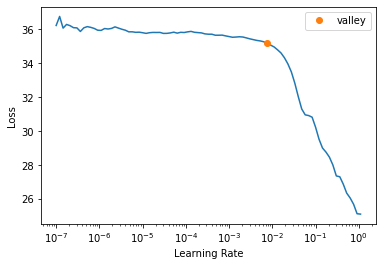

In [ ]:
learn.lr_find()

We're using the 1cycle technique to fit our model here, this is a relatively new technique that allows you to get convergence with less epochs. It works by varying the learning rate throughout the duration of the training.

In [ ]:
learn.fit_one_cycle(15, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,35.480759,34.794449,0.505870,00:00
1,35.110138,34.127522,0.527310,00:00
2,34.191406,32.740665,0.594691,00:00
3,31.878067,27.697437,0.794283,00:00
4,27.252832,18.318562,0.984176,00:00
5,21.049332,10.528173,0.994385,00:00
6,14.868093,5.116866,0.999490,00:01
7,9.783648,2.461658,0.998979,00:01
8,6.161551,1.388769,1.000000,00:01
9,3.807395,0.927864,1.000000,00:01


We can see that overfitting starts happening after epoch 10~, though it is not significant.

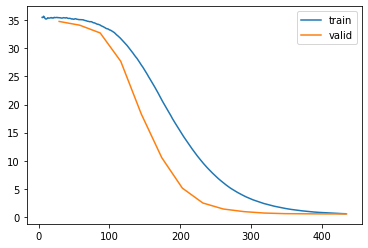

In [ ]:
learn.recorder.plot_loss()

Below is a table that shows the predictions the trained model made on a few rows from the training dataset.

In [ ]:
learn.show_results()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_pred
0,0.164062,-0.171352,-0.617041,0.850948,-0.325862,0.091823,1.052564,1.251322,1.859927,0.772795,-0.162844,7.0,5.783436
1,0.514517,5.401917,-2.029734,0.967509,-0.087211,0.552837,1.515971,1.008505,-0.237643,-0.266990,-1.222728,5.0,4.844957
2,-0.536845,-0.271771,-0.284642,-0.178672,-0.373592,-1.175968,-0.221805,0.244010,-0.303192,-0.007044,-0.733550,6.0,5.380746
3,0.280880,-0.171352,-0.118443,1.899994,-0.087211,-0.253939,0.728179,0.782116,-0.106545,-1.046828,0.570922,5.0,5.933052
4,-0.069573,0.129906,-0.949439,-0.586634,-0.516782,0.264703,-0.383998,-1.252163,-0.630938,-0.180341,1.467748,6.0,6.789744
5,-0.069573,0.431163,0.463253,0.617827,-0.946353,-0.081058,-0.337657,-0.392505,-0.040996,-1.220126,1.304689,6.0,6.757782
6,0.514517,-0.874287,1.294249,1.773720,0.581010,0.840972,-0.105954,1.884571,1.532182,-1.133477,-1.141198,7.0,5.699542
7,2.266786,-0.874287,-0.284642,-0.275806,-0.850893,-0.081058,-0.430339,-0.536873,-1.614173,-0.180341,0.570922,5.0,6.094469
8,-1.004117,-0.673449,0.047756,-0.858609,-0.182672,1.590121,-0.360828,-1.160285,1.663280,-0.613585,0.733981,6.0,6.314253


Below some example code is provided that does inference on one row. Feel free to modify it.

In [ ]:
df.iloc[4800]


fixed acidity             6.00000
volatile acidity          0.20000
citric acid               0.33000
residual sugar            1.10000
chlorides                 0.03900
free sulfur dioxide      45.00000
total sulfur dioxide    126.00000
density                   0.99051
pH                        3.31000
sulphates                 0.45000
alcohol                  11.60000
quality                   7.00000
Name: 4800, dtype: float64

In [ ]:
df.iloc[4800] = [7.00000,0.20000,0.33000,1.10000,0.03900,45.00000,126.00000,0.99051, 3.31000,0.45000,11.60000,5]


In [ ]:
row, clas, probs = learn.predict(df.iloc[4800])

In [ ]:
row.show()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.2,0.33,1.1,0.039,45.0,126.0,0.99051,3.31,0.45,11.6,6.787416


In [ ]:
clas, probs

(tensor([6.7874]), tensor([6.7874]))